### Import libraries

In [1]:
import time
import os
from os import listdir
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.image import imread
from sklearn.svm import SVC
from xgboost import XGBClassifier

import warnings
warnings.simplefilter("ignore", category=UserWarning)

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.layers import Input

from keras.models import load_model
from tensorflow.keras.applications import Xception
from keras.models import Model
from PIL import Image
from plot_keras_history import show_history, plot_history
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import joblib

start_time = time.time()


### Functions

In [3]:
def eval_model(model, hist, val_set, test_set):
    """
    Evaluate the performance of a machine learning model on the validation and test sets.

    Parameters:
    - model : The model to evaluate.
    - hist : The training history of the model.
    - val_set : The validation dataset.
    - test_set : The test dataset.
    """
    # Evaluation on the validation set 
    val_loss, val_accuracy = model.evaluate(val_set, verbose=False)
    print("Validation Accuracy: {:.4f}".format(val_accuracy))

    # Evaluation on the test set
    test_loss, test_accuracy = model.evaluate(test_set, verbose=False)
    print("Test Accuracy: {:.4f}".format(test_accuracy))

    show_history(hist)
    plot_history(hist)

   
    plt.close()
    

In [4]:
def plot_bad_images(model, data_generator, original_labels, num_images=5):
    """
    Fonction pour afficher les images mal classées par le modèle.

    Args:
        model : Le modèle utilisé pour les prédictions.
        data_generator : Le générateur de données.
        original_labels : Liste des étiquettes originales.
        num_images : Le nombre d'images mal classées à afficher (par défaut : 5).
    """

    # Obtenir les étiquettes réelles et prédites
    y_true = data_generator.classes
    y_pred_prob = model.predict(data_generator)
    y_pred_classes = np.argmax(y_pred_prob, axis=1)

    # Trouver les indices des images mal classées
    indices_mal_classes = np.where(y_true != y_pred_classes)[0]

    # Afficher les images mal classées
    plt.figure(figsize=(15, 8))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    # Parcourir les images mal classées
    for i in range(min(num_images, len(indices_mal_classes))):
        index = indices_mal_classes[i]
        chemin_image = data_generator.filepaths[index]

        img = plt.imread(chemin_image)

        # Afficher l'image avec la vraie classe et la prédiction
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f'Vraie classe : {original_labels[y_true[index]]}\nPrédiction : {original_labels[y_pred_classes[index]]}')
        plt.axis('off')

    # Afficher le résultat
    plt.show()
    

In [5]:
# Prétraiter les images pour le modèle Xception
def preprocess_image(img_path):
    """
    Prétraite une image pour le modèle Xception.

    Paramètres :
    - img_path: chemin vers le fichier image.
    """
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


In [6]:
# Fonction pour faire des prédictions avec le modèle Xception
def predict_image(model, img_path):
    """
    Fait des prédictions avec le modèle Xception.

    Paramètres :
    - model:  modèle Xception pré-entraîné.
    - img_path: chemin vers le fichier image.

    """
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    return predictions


In [7]:
# Créer des caractéristiques combinées (prédictions Xception + TF-IDF)
def create_combined_features(data, best_model_xception, path):
    """
    Crée des caractéristiques combinées en utilisant les prédictions Xception et TF-IDF.

    Paramètres :
    - data:  données d'entrée.
    - best_model_xception: modèle Xception pré-entraîné.
    - path: chemin vers les images.

    """
    # Extraire les caractéristiques textuelles en utilisant TF-IDF
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)
    tfidf_matrix = tfidf_vectorizer.fit_transform(data['clean_text'])

    # Prétraiter les caractéristiques d'image (prédictions Xception)
    image_features = np.array([predict_image(best_model_xception, os.path.join(path, img)) for img in data['image']])

    # Remodeler les caractéristiques d'image pour correspondre au nombre d'échantillons
    image_features_flat = image_features.reshape(len(image_features), -1)

    # Combinaison des caractéristiques
    combined_features = np.concatenate((tfidf_matrix.toarray(), image_features_flat), axis=1)

    return combined_features


In [8]:
def train_predict_evaluate(data, best_model_xception, path_to_images, classifier_type='random_forest'):
    """
    Entraîne, prédit et évalue un modèle en utilisant des caractéristiques combinées.

    Paramètres :
    - data: données d'entrée.
    - best_model_xception: modèle Xception pré-entraîné.
    - path_to_images: str, chemin vers les images.
    - classifier_type: str, type de classificateur ('random_forest' ou 'xgboost').
    """
    X = create_combined_features(data, best_model_xception, path_to_images)
    y = data['label_categ']

    # Diviser les données en ensembles d'entraînement et de validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialiser le classificateur en fonction du type choisi
    if classifier_type == 'random_forest':
        classifier = RandomForestClassifier(random_state=42)
    elif classifier_type == 'xgboost':
        classifier = XGBClassifier(random_state=42)
    else:
        raise ValueError("Classifier type must be 'random_forest' or 'xgboost'.")

    # Entraîner le classificateur
    classifier.fit(X_train, y_train)

    # Sauvegarder le modèle entraîné dans un fichier
    joblib.dump(classifier, '../models/classifier.pkl')

    print("Modèle sauvegardé avec succès")

    # Prédire les catégories pour l'ensemble de validation
    val_predictions = classifier.predict(X_val)

    # Évaluer le modèle
    accuracy = accuracy_score(y_val, val_predictions)
    precision = precision_score(y_val, val_predictions, average='weighted')
    recall = recall_score(y_val, val_predictions, average='weighted')
    f1 = f1_score(y_val, val_predictions, average='weighted')

    conf_matrix = confusion_matrix(y_val, val_predictions)
    class_report = classification_report(y_val, val_predictions)

    print("Précision : {:.2f}".format(accuracy))
    print("Précision : {:.2f}".format(precision))
    print("Rappel : {:.2f}".format(recall))
    print("Score F1 : {:.2f}".format(f1))
    print("\nMatrice de confusion :")
    print("\nRapport de classification :")
    print(class_report)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_,
            yticklabels=classifier.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

### Import fichiers

In [9]:
# Importation du jeu de données
data = pd.read_csv('../data/processed/df2.csv')

# Recupération d'un dataset avec image et leur label
data_image = data[["image", "label_categ","clean_text"]]
path = "../data/raw/Images/"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

data_image.loc[:, "image"] = data_image.image.apply(lambda x: path + str(x))

1050


In [10]:
# Redimensionner toutes les images du dataset
for image_path in data_image.image:
    preprocess_image(image_path)

In [11]:
label = ['0', '1', '2', '3', '4', '5', '6']

# Parcourir les labels
for i in range(len(label)):
    # Filtrer les données pour le label actuel
    data_verif = data.loc[data['label_categ'] == i]

    # Récupérer la catégorie correspondante
    cat = data_verif['categ_1'].iloc[0]

    # Afficher le mapping entre le label et la catégorie
    print('Le label {} correspond à la catégorie suivante :  {}' .format(i, cat))

Le label 0 correspond à la catégorie suivante :  Baby Care
Le label 1 correspond à la catégorie suivante :  Beauty and Personal Care
Le label 2 correspond à la catégorie suivante :  Computers
Le label 3 correspond à la catégorie suivante :  Home Decor & Festive Needs
Le label 4 correspond à la catégorie suivante :  Home Furnishing
Le label 5 correspond à la catégorie suivante :  Kitchen & Dining
Le label 6 correspond à la catégorie suivante :  Watches


In [12]:
# création variable original_labels
original_labels = ['Home Furnishing', 'Baby Care', 'Watches', 'Home Decor & Festive Needs', 'Kitchen & Dining', 'Beauty and Personal Care', 'Computers']

### Préparation des données

In [13]:
# Sélectionner les caractéristiques et les étiquettes
X = data_image["image"]
y = data_image["label_categ"].astype(str)

In [14]:
# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [15]:
# Diviser l'ensemble de test en ensembles de test et de validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.3, random_state = 42)

### Création datagenerator
Un générateur de données d'images est un outil essentiel dans le domaine de l'apprentissage automatique, notamment dans le contexte de la vision par ordinateur. Dans cet exemple, le code utilise la classe ImageDataGenerator fournie par la bibliothèque Keras/TensorFlow pour augmenter la diversité des données d'entraînement.

Les paramètres spécifiés dans le générateur indiquent différentes transformations à appliquer aux images d'origine. Ces transformations incluent une rotation maximale de 20 degrés, un décalage horizontal et vertical de 20%, une inclinaison de 20 degrés, un zoom de 20%, et une inversion horizontale. De plus, la valeur des pixels est normalisée en divisant par 255 à l'aide du paramètre rescale.

L'objectif de ces transformations est d'accroître la variabilité des données d'entraînement, ce qui peut améliorer les performances du modèle en lui permettant de généraliser mieux aux nouvelles données. En ajustant ces paramètres, on peut personnaliser le niveau d'augmentation des données en fonction des besoins spécifiques du projet.

In [16]:
# Créer un générateur d'images
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             rescale=1./255)

In [17]:
# création df pour train, test et validation
df_train = pd.DataFrame({"image": X_train, "label_categ": y_train})
df_test = pd.DataFrame({"image": X_test, "label_categ": y_test})
df_val = pd.DataFrame({"image": X_val, "label_categ": y_val})

In [18]:
# génération images pour set enrainement
train_generator = datagen.flow_from_dataframe(dataframe=df_train,
                                              x_col="image",
                                              y_col="label_categ",
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode="categorical")

# Génerer des images pour le set de test
test_generator = datagen.flow_from_dataframe(dataframe=df_test,
                                             x_col="image",
                                             y_col="label_categ",
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode="categorical")

# génerer images pour set de validation
val_generator = datagen.flow_from_dataframe(dataframe=df_val,
                                            x_col="image",
                                            y_col="label_categ",
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode="categorical")

Found 735 validated image filenames belonging to 7 classes.
Found 220 validated image filenames belonging to 7 classes.
Found 95 validated image filenames belonging to 7 classes.


### Modélisation

In [19]:
# Création du Early Stop
early_stop = EarlyStopping(monitor='val_loss',patience=2)

# Définir le nombre d'itérations d'entraînement
epochs = 30

### CNN
Un réseau de neurones convolutionnel (CNN), ou ConvNet en abrégé, est un type de modèle de réseau de neurones particulièrement adapté à la reconnaissance de motifs dans des données visuelles, telles que des images. Ce type de réseau a été conçu pour imiter le processus de vision humaine et est largement utilisé dans des domaines tels que la vision par ordinateur et l'analyse d'images.

La caractéristique principale d'un CNN réside dans son architecture, qui comprend des couches de convolution. Ces couches permettent au réseau d'apprendre automatiquement des caractéristiques pertinentes à partir des données d'entrée, en utilisant des filtres qui glissent sur la région de l'image. Les opérations de mise en commun sont également utilisées pour réduire la dimension de la sortie de la couche de convolution.

In [20]:
# Créer le modèle
model_cnn = Sequential()
model_cnn.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(7, activation='softmax'))

# Compiler le modèle
model_cnn.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Afficher un résumé du modèle
model_cnn.summary()

checkpoint = ModelCheckpoint("../models/best_model_cnn.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Entraîner le modèle sur les données d'entraînement
history_cnn = model_cnn.fit(train_generator,
                            batch_size=32,
                            epochs=epochs,
                            validation_data=val_generator,
                            validation_batch_size=32,
                            callbacks=[early_stop, checkpoint])

# Charger le meilleur modèle
best_model_cnn = load_model("../models/best_model_cnn.h5")

# Temps d'exécution
end_time = time.time()
execution_time = end_time - start_time
print("Temps d'exécution de la cellule : ", execution_time, " secondes")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 788544)            0         
                                                                 
 dense (Dense)               (None, 128)               100933760 
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 100936455 (385.04 MB)
Trainable params: 100936455 (385.04 MB)
Non-trainable params: 0 (0.00 Byte)
__________

Validation Accuracy: 0.2842
Test Accuracy: 0.3000


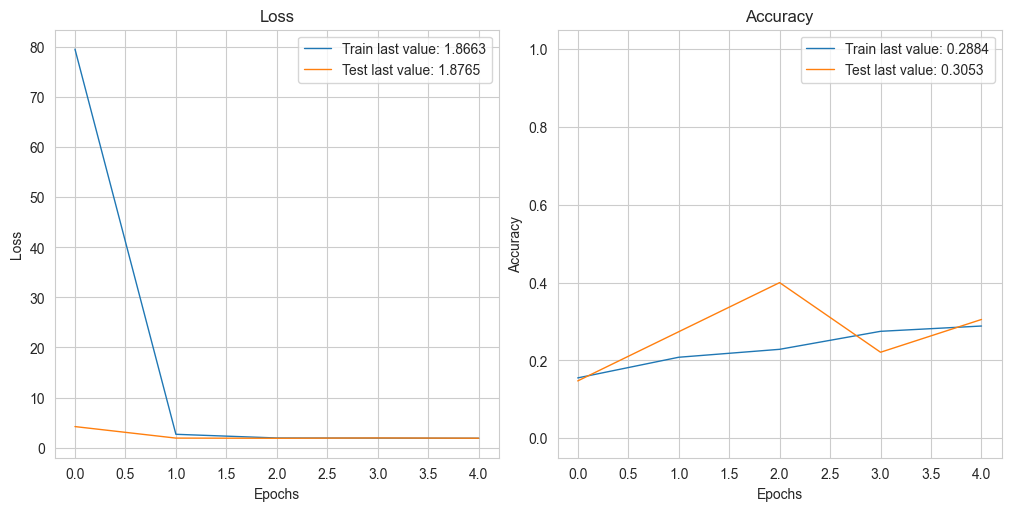

In [21]:
eval_model(best_model_cnn,history_cnn,val_generator,test_generator)

### InceptionV3
InceptionV3 tire son nom du concept "Inception", qui signifie l'idée d'intégrer des informations à différentes échelles spatiales dans un réseau. Ce modèle a été spécialement conçu pour résoudre le problème du choix de la taille des filtres dans les couches de convolution. Plutôt que d'utiliser des filtres de taille fixe, InceptionV3 utilise des filtres de différentes tailles simultanément.

In [22]:
# Définir le tenseur d'entrée
inputs = Input(shape=(224, 224, 3))

# Charger le modèle InceptionV3 pré-entraîné avec les poids pré-entraînés
inception_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=inputs)

# Geler les couches pré-entraînées
for layer in inception_base.layers:
    layer.trainable = False

# Ajouter des couches supérieures personnalisées pour votre tâche spécifique
x = GlobalAveragePooling2D()(inception_base.output)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)  # Couche de sortie avec 7 neurones et activation softmax

# Créer le modèle final
model_inception = Model(inputs=inputs, outputs=predictions)

# Compiler le modèle
model_inception.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Afficher un résumé du modèle
model_inception.summary()

checkpoint = ModelCheckpoint("../models/best_model_inception.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Entraîner le modèle sur les données d'entraînement
history_inception = model_inception.fit(train_generator,
                                        batch_size=32,
                                        epochs=epochs,
                                        validation_data=val_generator,
                                        validation_batch_size=32,
                                        callbacks=[early_stop, checkpoint])

# Charger le meilleur modèle basé sur la précision de validation
best_model_inception = load_model("../models/best_model_inception.h5")

# Calculer et afficher le temps d'exécution
end_time = time.time()
execution_time = end_time - start_time
print("Temps d'exécution de la cellule : ", execution_time, " secondes")


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d_1[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

Validation Accuracy: 0.8737
Test Accuracy: 0.8182


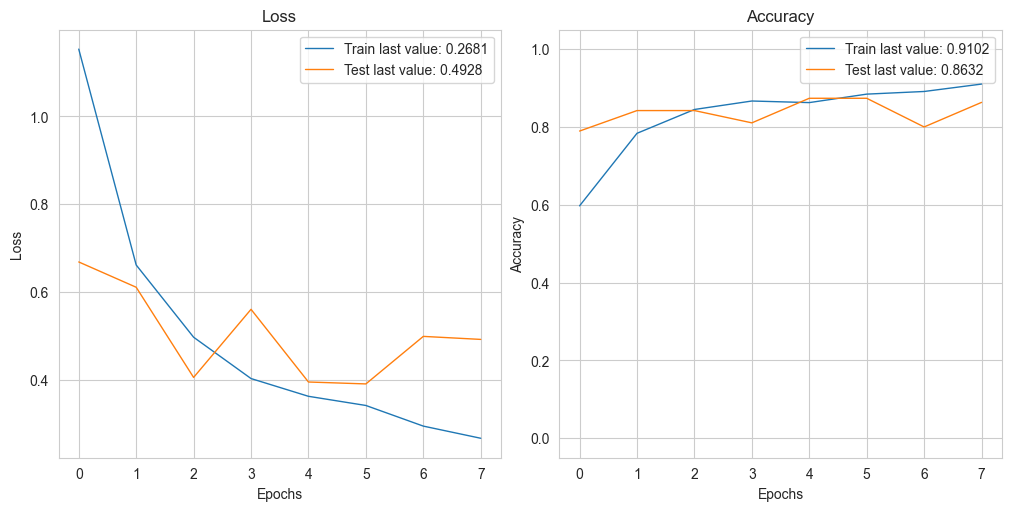

In [23]:
eval_model(best_model_inception,history_inception,val_generator,test_generator)

### RESNET 50
ResNet-50 tire son nom de l'idée centrale des "raccourcis résiduels" ou "skip connections". Ces raccourcis sont des connexions directes qui contournent certaines couches du réseau, permettant aux informations de se propager plus facilement à travers le réseau, même lorsqu'il devient très profond. Cette architecture résout le problème du "vanishing gradient" (gradient qui tend à disparaître) et permet l'entraînement réussi de réseaux extrêmement profonds.

La structure de ResNet-50 comprend plusieurs blocs résiduels, chacun contenant des couches de convolution, de normalisation et d'activation, avec l'ajout des connexions résiduelles. Ces blocs facilitent l'apprentissage des représentations complexes en hiérarchie.

In [24]:
# Définir le tenseur d'entrée
inputs = Input(shape=(224, 224, 3))

# Charger le modèle ResNet50 pré-entraîné avec des poids pré-entraînés
resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

# Geler les couches pré-entraînées
for layer in resnet_base.layers:
    layer.trainable = False

# Ajouter des couches supérieures personnalisées pour ma tâche spécifique
x = MaxPooling2D(pool_size=(2, 2))(resnet_base.output)  # Couche de mise en commun
x = Flatten()(x)  # Couche de dépliement
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)  # Couche de sortie avec 7 neurones et activation softmax

# Créer le modèle final
model_resnet = Model(inputs=inputs, outputs=predictions)

# Compiler le modèle
model_resnet.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Afficher un résumé du modèle
model_resnet.summary()

# Point de contrôle pour sauvegarder le meilleur modèle
checkpoint = ModelCheckpoint("../models/best_model_resnet50.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
# Entraîner le modèle sur les données d'entraînement
history_resnet = model_resnet.fit(train_generator,
                                  batch_size=32,
                                  epochs=epochs,
                                  validation_data=val_generator,
                                  validation_batch_size=32,
                                  callbacks=[early_stop, checkpoint])

# Charger le meilleur modèle basé sur la précision de validation
best_model_resnet = load_model("../models/best_model_resnet50.h5")
# Calculer et afficher le temps d'exécution
end_time = time.time()
execution_time = end_time - start_time
print("Temps d'exécution de la cellule : ", execution_time, " secondes")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

Validation Accuracy: 0.3158
Test Accuracy: 0.3182


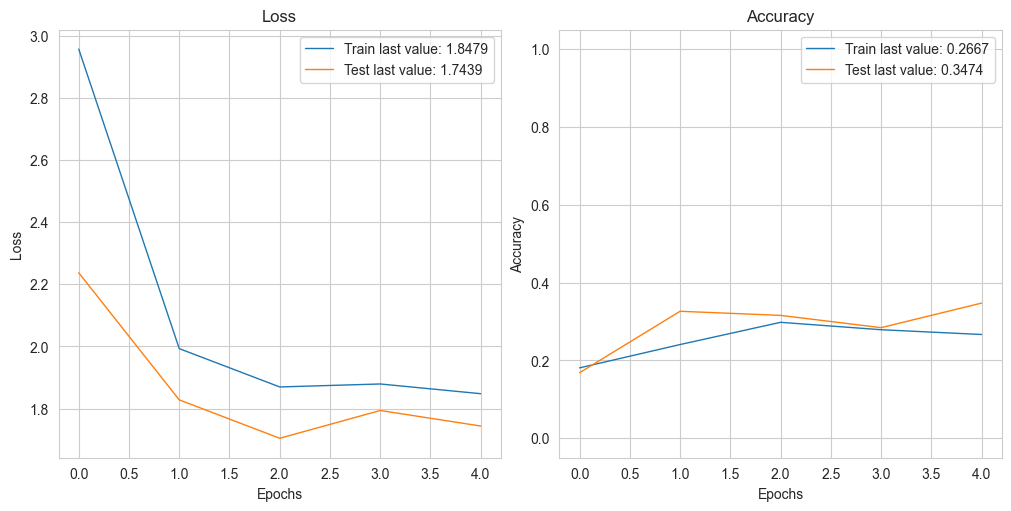

In [25]:
eval_model(best_model_resnet, history_resnet,val_generator,test_generator)

### Xception
Xception, une abréviation de "Exceptional Networks for Exceptional Accuracy", est un modèle de réseau de neurones convolutionnel (CNN) développé par Google. Il est conçu pour offrir une meilleure précision tout en conservant une architecture relativement plus simple par rapport à d'autres modèles de pointe.

In [26]:
# Définir le tenseur d'entrée
inputs = Input(shape=(224, 224, 3))

# Charger le modèle Xception pré-entraîné avec les poids pré-entraînés
xception_base = Xception(weights='imagenet', include_top=False, input_tensor=inputs)

# Geler les couches pré-entraînées
for layer in xception_base.layers:
    layer.trainable = False

# Ajouter des couches supérieures personnalisées pour votre tâche spécifique
x = GlobalAveragePooling2D()(xception_base.output)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

predictions = Dense(7, activation='softmax')(x)  # Couche de sortie avec 7 neurones et activation softmax

# Créer le modèle final
model_xception = Model(inputs=inputs, outputs=predictions)

# Compiler le modèle
model_xception.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Afficher un résumé du modèle
model_xception.summary()

checkpoint = ModelCheckpoint("../models/best_model_xception.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Entraîner le modèle sur les données d'entraînement
history_xception = model_xception.fit(train_generator,
                                      batch_size=32,
                                      epochs=epochs,
                                      validation_data=val_generator,
                                      validation_batch_size=32,
                                      callbacks=[early_stop, checkpoint])

# Charger le meilleur modèle basé sur la précision de validation
best_model_xception = load_model("../models/best_model_xception.h5")

# Calculer et afficher le temps d'exécution
end_time = time.time()
execution_time = end_time - start_time
print("Temps d'exécution de la cellule : ", execution_time, " secondes")


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]'

Validation Accuracy: 0.8737
Test Accuracy: 0.8318


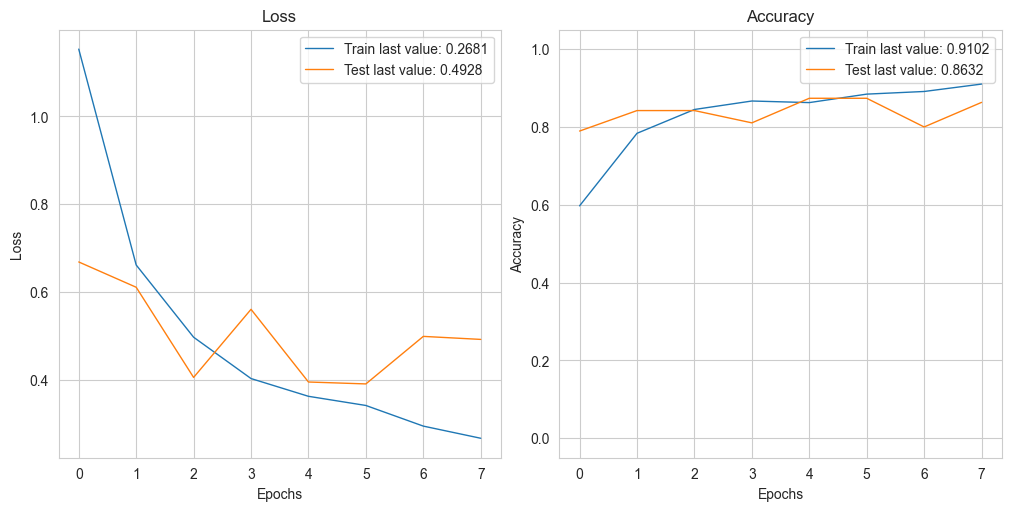

In [27]:
eval_model(best_model_xception,history_inception,val_generator,test_generator)

#### Differences entre InceptionV3 et Xception
On vas plotter des images qui ont été mal classé, pour observer le comportement du modèle inceptionV3 et xception

3/3 [==============================] - 3s 632ms/step


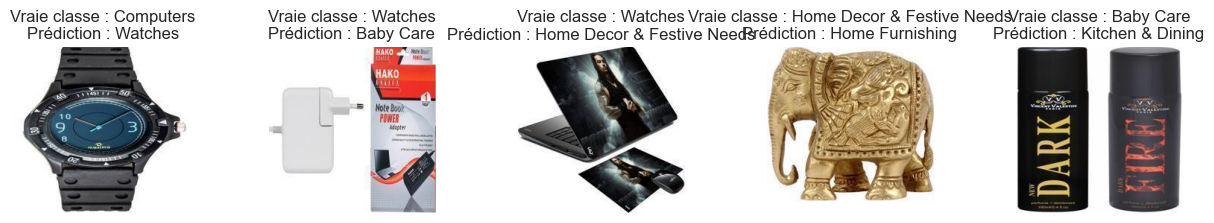

In [28]:
plot_bad_images(best_model_inception, val_generator, original_labels)

3/3 [==============================] - 4s 1s/step


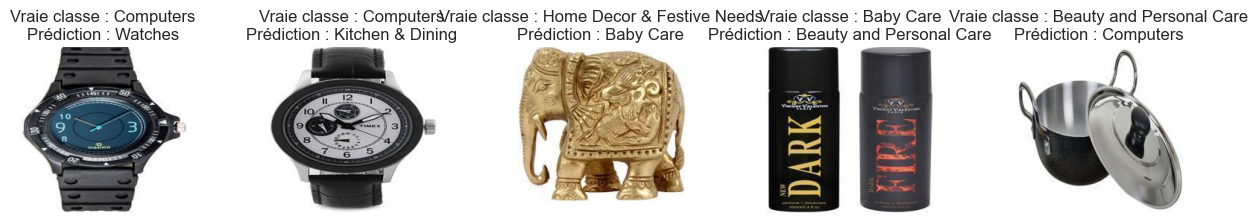

In [29]:
plot_bad_images(best_model_xception, val_generator, original_labels)

### Modèle combinée
Maintenant, on va passer à l'étape suivante. On va prétraiter les images pour les adapter au modèle Xception. La fonction preprocess_image s'occupe de redimensionner les images à une taille spécifique et de les convertir en tableaux numériques. Ensuite, avec la fonction predict_image, on va utiliser le modèle Xception pour faire des prédictions sur une image donnée.

Pour enrichir notre modèle, on combine les caractéristiques textuelles (TF-IDF) avec les prédictions du modèle Xception grâce à la fonction create_combined_features. Cela nous permet de tirer parti des informations à la fois textuelles et visuelles.

Enfin, pour entraîner et évaluer notre modèle, on utilise la fonction train_predict_evaluate. Elle divise les données en ensembles d'entraînement et de validation, utilise un classificateur Random Forest et xgboost pour former le modèle, puis évalue ses performances avec différentes métriques comme la précision, le rappel et le score F1. On n'oublie pas de sauvegarder notre modèle entraîné pour une utilisation future.

1/1 [==============================] - 0s 75ms/step
Modèle sauvegardé avec succès
Précision : 0.92
Précision : 0.92
Rappel : 0.92
Score F1 : 0.92

Matrice de confusion :

Rapport de classification :
              precision    recall  f1-score   support

           0       0.92      0.81      0.86        27
           1       0.87      0.95      0.91        21
           2       0.92      0.87      0.89        38
           3       0.88      0.93      0.90        30
           4       0.94      0.91      0.93        35
           5       0.93      1.00      0.96        26
           6       1.00      1.00      1.00        33

    accuracy                           0.92       210
   macro avg       0.92      0.93      0.92       210
weighted avg       0.92      0.92      0.92       210


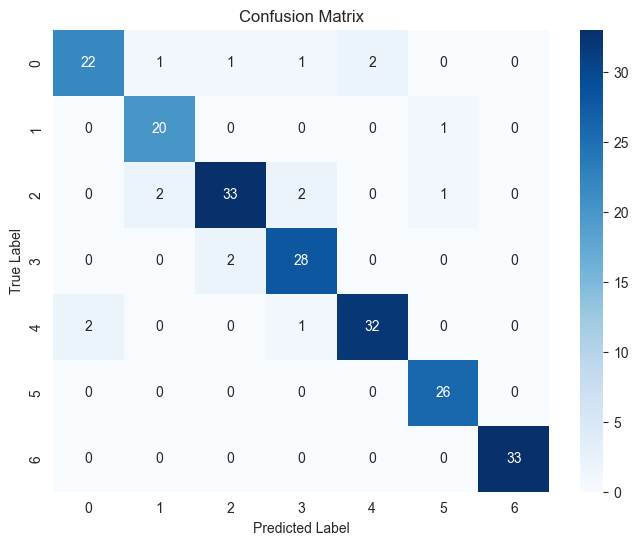

In [30]:
train_predict_evaluate(data, best_model_xception, path,classifier_type='random_forest')

1/1 [==============================] - 0s 51ms/step
Modèle sauvegardé avec succès
Précision : 0.91
Précision : 0.91
Rappel : 0.91
Score F1 : 0.91

Matrice de confusion :

Rapport de classification :
              precision    recall  f1-score   support

           0       0.84      0.78      0.81        27
           1       0.86      0.90      0.88        21
           2       0.94      0.84      0.89        38
           3       0.91      0.97      0.94        30
           4       0.94      0.91      0.93        35
           5       0.83      0.96      0.89        26
           6       1.00      1.00      1.00        33

    accuracy                           0.91       210
   macro avg       0.90      0.91      0.91       210
weighted avg       0.91      0.91      0.91       210


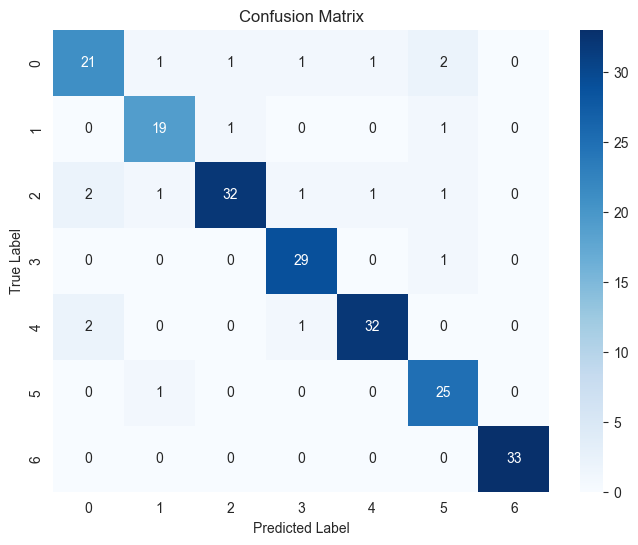

In [31]:
train_predict_evaluate(data, best_model_xception,path, classifier_type='xgboost')